# <span style='color:blue'>   TP3 : Modèles probabilistes génératifs pour le Machine Learning</span>

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import string as str
import pandas as pd

## <span style='color:green'>   Ex1. Classification de texte avec le modèle Naive Bayes </span>

### <span style='color:black'>   1.1 Les données </span>

In [75]:
from load_ag_news import load_ag_news

path = ""

train_set, test_set = load_ag_news(path)

### <span style='color:black'>   1.2 Développer un Naive Bayes </span>

#### <span style='color:black'>-   Estimation des paramètres </span>

In [76]:
# Créer un array des labels à partir du train_set : 
labels = []
for sentence in train_set : 
    labels.append(sentence[0])
labels = np.array(labels)

In [77]:
# Retrouver les différentes valeurs et leur dénombrement
label_unique, label_count = np.unique(labels, return_counts = True)
label_unique, label_count

(array([0, 1, 2, 3]), array([30000, 30000, 30000, 30000]))

In [78]:
# Estimation de π
pi = {}
for i in range(len(label_unique)):
    pi[i] = label_count[i]/label_count.sum()
    
for i,j in pi.items():
    print('π({}) = {}'.format(i,j)) 

π(0) = 0.25
π(1) = 0.25
π(2) = 0.25
π(3) = 0.25


In [79]:
np.sum(list(pi.values()))

1.0

In [80]:
# Estimation de b

B = {}
for label in label_unique:
    b={}
    for sentence in train_set:
        if sentence[0] == label:
            for word in sentence[1]:
                if word not in b : 
                    b[word] = 1
                else : 
                    b[word] += 1
    sum_i = np.sum(list(b.values()))
    b = {key : value/sum_i for key,value in b.items()}
    B[label] = b

In [81]:
for i in range(len(label_count)):
    print(B[i]['London'])

0.00020850882196292924
0.00018036294574312617
0.00014763636417864596
0.00011897389590699292


#### <span style='color:black'> -  Prédiction sur la phrase ["Arsenal", "is", "a", "londonian", "team", "."] </span>

In [82]:
%%time
# Version list
e = 10**(-5)

phrase = ["Arsenal", "is", "a", "londonian", "team", "."]

P=[]
for label in label_unique :
    p=pi[label]
    for word in phrase : 
        p = p *(B[label].get(word,0)+e)
    P.append(p)
    s = np.sum(P)
P = [elt/s for elt in P]
P, max(P), P.index(max(P))

CPU times: user 113 µs, sys: 23 µs, total: 136 µs
Wall time: 245 µs


([0.0028278170810995774,
  0.9924989725858532,
  0.0007448195290411271,
  0.003928390804006227],
 0.9924989725858532,
 1)

In [83]:
%%time
# Version Dict
e = 10**(-5)

phrase = ["Arsenal", "is", "a", "londonian", "team", "."]

P={}
for label in label_unique:
    p = pi[label]
    for word in phrase : 
        p = p *(B[label].get(word,0)+e)
    P[label] = p
s = np.sum(list(P.values()))
P = {key : value/s for (key,value) in P.items()} 
P, max(P, key=P.get)


CPU times: user 98 µs, sys: 0 ns, total: 98 µs
Wall time: 99.9 µs


({0: 0.0028278170810995774,
  1: 0.9924989725858532,
  2: 0.0007448195290411271,
  3: 0.003928390804006227},
 1)

#### <span style='color:black'> -  Prédiction sur le corpus test </span>

In [84]:
%%time 
# Version sans passage en logarithme
e = 10**(-5)

def pred(epsilon):
    results = []
    for sentence in test_set:
        phrase = sentence[1]
        P={}
        for label in label_unique:
            p = pi[label]
            for word in phrase : 
                p = p *(B[label].get(word,0)+epsilon)
            P[label] = p
        s = np.sum(list(P.values()))
        P = {key : value/s for (key,value) in P.items()} 
        
        results.append(max(P, key=P.get))
    results = np.array(results)
    réel = np.array([sentence[0] for sentence in test_set])
    acc = np.round(((results == réel).sum()/len(results))*100,2)
    print("L'erreur de classification en Naïve Bayes est de : {} %".format(100 - acc))
    return 

pred(e)

<timed exec>:15: RuntimeWarning: invalid value encountered in double_scalars


L'erreur de classification en Naïve Bayes est de : 10.89 %
CPU times: user 454 ms, sys: 5.74 ms, total: 460 ms
Wall time: 462 ms


In [85]:
#Version passage au logarithme

def pred(epsilon):
    results = []
    for sentence in test_set:
        phrase = sentence[1]
        P={}
        for label in label_unique:
            p=np.log(pi[label])
            for word in phrase : 
                p = p + np.log(B[label].get(word,0)+epsilon)
            P[label] = p
        s = np.sum(list(P.values()))
        P = {key : value - s for (key,value) in P.items()}
        
        results.append(max(P, key=P.get))
    results = np.array(results)
    réel = np.array([sentence[0] for sentence in test_set])
    acc = (1-((results == réel).sum()/len(results))) * 100
    print("Pour epsilon = {}\nL'erreur de classification en Naïve Bayes est de : {} %\n\n".format(epsilon,np.round(acc,2)))
    return 

In [86]:
%%time
pred(10**(-5))
pred(10**(-10))
pred(1)


Pour epsilon = 1e-05
L'erreur de classification en Naïve Bayes est de : 10.59 %


Pour epsilon = 1e-10
L'erreur de classification en Naïve Bayes est de : 9.89 %


Pour epsilon = 1
L'erreur de classification en Naïve Bayes est de : 50.91 %


CPU times: user 4.69 s, sys: 19.5 ms, total: 4.71 s
Wall time: 4.74 s


<span style='color:red'><b>Commentaire</b></span>  
On peut conclure que l'ajout d'un epsilon aide à éviter le problème du underflow.  
Ceci reste vrai à condition que cet epsilon ne soit pas trop important au point de prédominer sur les calculs (epsilon=1).  
Plus la valeur de epsilon est petite, meilleure est l'efficacité de notre algorithme

## <span style='color:green'>   Ex2. Étiquetage morpho-syntaxique avec une chaîne de Markov cachée </span>

### <span style='color:black'>   2.1 Introduction </span>

In [254]:
from load_conll2000 import load_conll2000

path = ""
train_set, test_set = load_conll2000(path)

### <span style='color:black'>   2.2 Développer une chaîne de Markov cachée </span>

#### <span style='color:black'>   2.2.1.a - Estimation des paramètres - π </span>

In [255]:
%%time
# Crérer un array avec tous les labels des mots

all_labels = []
for sentence in train_set:
    for pair in sentence:
        all_labels.append(pair[0])
#all_labels = np.array(all_labels) # We use lists because they are faster than arrays
#all_labels, 
len(all_labels)

CPU times: user 18.8 ms, sys: 1.38 ms, total: 20.2 ms
Wall time: 21.8 ms


211727

In [256]:
# Retrouver les différentes valeurs et leur dénombrement
labels, labels_count = np.unique(all_labels, return_counts = True)
pi = dict(zip(labels, labels_count))

# Normalisation
for (k,v) in pi.items():
    pi[k]  = pi[k] / np.sum(list(pi.values()))

# Affichage
for i, j in pi.items():
    print('π({}) = {}'.format(i,j)) 

π(ADJ) = 0.06759648037331091
π(ADP) = 0.11573078123246217
π(ADV) = 0.04351881227839763
π(CCONJ) = 0.03217320793212053
π(DET) = 0.13156619732682787
π(INTJ) = 0.00010688450920251648
π(NOUN) = 0.31189383169873564
π(NUM) = 0.08611431068979036
π(PART) = 0.07762673982628474
π(PRON) = 0.05596313541393536
π(PROPN) = 0.2642445213870872
π(PUNCT) = 0.42846641093960697
π(SYM) = 0.05545993290422492
π(VERB) = 0.9987001674445705
π(X) = 0.9343689094843107


In [257]:
pi['ADJ']

0.06759648037331091

#### <span style='color:black'>   2.2.1.b - Estimation des paramètres - Matrice A </span>

In [258]:
%%time
# Version Dict

n = len(all_labels)

# Initialisation de la matrice A
A = {key:{key:0 for key in pi.keys()} for key in pi.keys()}

for i in range(n-1) : 
    A[all_labels[i]][all_labels[i+1]] +=1
    
# Normalisation
A = {Key : \
     {key : value / np.sum(list(A[Key].values())) for (key,value) in A[Key].items()} \
     for Key in A.keys()}

# Test valeur TP
A['NUM']['NOUN']

CPU times: user 68.9 ms, sys: 1.22 ms, total: 70.1 ms
Wall time: 69.2 ms


0.3480457005411906

#### <span style='color:black'>   2.2.1.c - Estimation des paramètres - b </span>

In [259]:
labels

array(['ADJ', 'ADP', 'ADV', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART',
       'PRON', 'PROPN', 'PUNCT', 'SYM', 'VERB', 'X'], dtype='<U5')

In [260]:
# Estimation de b

B = {}
for label in labels:
    b={}
    for sentence in train_set:
        for tuple in sentence:
            if tuple[0] == label:
                if tuple[1] not in b : 
                    b[tuple[1]] = 1
                else :
                    b[tuple[1]] +=1
    sum_label = np.sum(list(b.values()))
    b = {key:value/sum_label for key,value in b.items()}
    B[label] = b
B['PUNCT']['.']

0.36019485612847296

In [261]:
B['PRON']['I']

0.07091108671789242

### <span style='color:black'>   2.2.2 Coder l'algorithme Forward/Backward </span>

In [262]:
# Fonction qui prend un mot et renvoie son label :
def Labelize(word):
    for sentence in train_set:
        for pair in sentence:
            if pair[1] == word:
                return pair[0]

In [263]:
Labelize('moon')

'NOUN'

In [264]:
labels

array(['ADJ', 'ADP', 'ADV', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART',
       'PRON', 'PROPN', 'PUNCT', 'SYM', 'VERB', 'X'], dtype='<U5')

In [265]:
sentence = ["I", "am", "a","student", "in", "a", "French", "school","."]

In [266]:
{word : {} for word in sentence}

{'I': {},
 'am': {},
 'a': {},
 'student': {},
 'in': {},
 'French': {},
 'school': {},
 '.': {}}

#### <span style='color:black'>   2.2.2.a - Coder l'algorithme Forward (Lissé & Normalisé)</span>

In [267]:
def Forward(sentence, epsilon) : 
    alpha = {word : {} for word in sentence}

    word_0 = sentence[0]
    alpha[word_0]={}
    for label in labels : 
        alpha[word_0][label] = pi[label] * (B[label].get(word_0,0)+epsilon)
    s = np.sum(list(alpha[word_0].values()))
    alpha[word_0] = {key:value/s for (key,value) in alpha[word_0].items()}

    for i in range(1,len(sentence)):
        previous_word = sentence[i-1]
        current_word = sentence[i]    

        previous_label = Labelize(previous_word)
        current_label = Labelize(current_word)

        for label in labels:

            x = 0
            for lab in labels:
                x += alpha[previous_word][lab] * A[lab][label]

            alpha[current_word][label] = (B[label].get(current_word,0)+epsilon) * x
        s = np.sum(list(alpha[current_word].values()))
        alpha[current_word] = {key:value/s for (key,value) in alpha[current_word].items()}
        
    return alpha

In [268]:
%%time
epsilon = 10**(-5)
alpha = Forward(sentence, epsilon)
#alpha

CPU times: user 30.4 ms, sys: 1.3 ms, total: 31.7 ms
Wall time: 32.2 ms


#### <span style='color:black'>   2.2.2.b - Coder l'algorithme Backward (Lissé & Normalisé)</span>

In [271]:
def Backward(sentence, epsilon):
    beta = {}

    last_word = sentence[-1]
    beta[last_word]={}
    for label in labels : 
        beta[last_word][label] = 1
    s = np.sum(list(beta[last_word].values()))
    beta[last_word] = {key:value/s for (key,value) in beta[last_word].items()}

    l = len(sentence)
    for i in range(l-1,0,-1):
        previous_word = sentence[i-1]
        current_word = sentence[i]    

        previous_label = Labelize(previous_word)
        current_label = Labelize(current_word)

        beta[previous_word]={}

        for label in labels:

            x = 0
            for lab in labels:
                x += (beta[current_word].get(lab,0)+epsilon) * A[label][lab] * (B[lab].get(current_word,0)+epsilon)

            beta[previous_word][label] = x
        s = np.sum(list(beta[previous_word].values()))
        beta[previous_word] = {key:value/s for (key,value) in beta[previous_word].items()}
    return beta

In [272]:
%%time
epsilon = 10**(-5)
beta = Backward(sentence, epsilon)
beta

CPU times: user 23.7 ms, sys: 7.53 ms, total: 31.2 ms
Wall time: 44.9 ms


{'.': {'ADJ': 0.06666666666666667,
  'ADP': 0.06666666666666667,
  'ADV': 0.06666666666666667,
  'CCONJ': 0.06666666666666667,
  'DET': 0.06666666666666667,
  'INTJ': 0.06666666666666667,
  'NOUN': 0.06666666666666667,
  'NUM': 0.06666666666666667,
  'PART': 0.06666666666666667,
  'PRON': 0.06666666666666667,
  'PROPN': 0.06666666666666667,
  'PUNCT': 0.06666666666666667,
  'SYM': 0.06666666666666667,
  'VERB': 0.06666666666666667,
  'X': 0.06666666666666667},
 'school': {'ADJ': 0.03007162165619925,
  'ADP': 0.005848133297136348,
  'ADV': 0.07051127763951903,
  'CCONJ': 0.006323797769262416,
  'DET': 0.004300941294581606,
  'INTJ': 0.3359895092038843,
  'NOUN': 0.11619899908742078,
  'NUM': 0.08938368428535937,
  'PART': 0.003356881317408476,
  'PRON': 0.024051773317031743,
  'PROPN': 0.09744634955288539,
  'PUNCT': 0.04217342977023798,
  'SYM': 1.2719508898330261e-05,
  'VERB': 0.02963916244415323,
  'X': 0.1446917198560215},
 'French': {'ADJ': 0.23489947724545657,
  'ADP': 0.06409860

#### <span style='color:black'>   2.2.2.c - Coder la fonction de prédiction</span>

In [273]:
# Définir la fonction qui calcule le dict Gamma
def Gamma(alpha, beta):
    gamma = {word : {} for word in sentence}
    for word in sentence : 
        for label in labels:
            gamma[word][label] = alpha[word][label] * beta[word][label]
    s = np.sum(list(gamma[word].values()))
    gamma[word] = {key:value/s for (key,value) in gamma[word].items()}  
    return gamma

In [276]:
gamma = Gamma(alpha, beta)


In [236]:
def predict_sentence(sentence, epsilon, gamma):

    pred = []
    for word in sentence :
        pred.append(max(gamma[word], key=gamma[word].get))
    return pred

In [237]:
%%time
predict_sentence(sentence, epsilon, gamma) #== [Labelize(word) for word in sentence]

CPU times: user 70 µs, sys: 18 µs, total: 88 µs
Wall time: 93 µs


['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']

In [238]:
%%time
predict_sentence(sentence, epsilon, gamma) == [Labelize(word) for word in sentence]

CPU times: user 27.4 ms, sys: 2.92 ms, total: 30.3 ms
Wall time: 29 ms


True

#### <span style='color:black'>   2.2.2.d - Appliquer au test set </span>

In [239]:
def Predict(set, epsilon):
    score = []
    for item in set:
        labels = [pair[0] for pair in item]
        sentence = [pair[1] for pair in item]
        alpha = Forward(sentence, epsilon)
        beta = Backward(sentence, epsilon)
        
        #gamma = Gamma(alpha, beta)
        # L'appel direct de la fonction Gamma renvoie une erreur. On effectue donc le calcul de gamma directement dans la fonction
        gamma = {word : {} for word in sentence}
        for word in sentence : 
            for label in labels:
                gamma[word][label] = alpha[word][label] * beta[word][label]
        s = np.sum(list(gamma[word].values()))
        gamma[word] = {key:value/s for (key,value) in gamma[word].items()} 
        
        pred_item = predict_sentence(sentence,epsilon, gamma)
        score_item = np.mean([pred_item[i] == labels[i] for i in range(len(labels))])
        score.append(score_item)
    return np.mean(score)

In [242]:
%%time
epsilon = 10**(-5)
set = test_set
Predict(set, epsilon)

CPU times: user 3min 47s, sys: 755 ms, total: 3min 47s
Wall time: 3min 50s


0.9425101826485638

## <span style='color:green'>   Ex3. Le filtre de Kalman </span>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path = ""
X = np.loadtxt(path + "signal_X.txt")
Y = np.loadtxt(path + "signal_Y.txt")

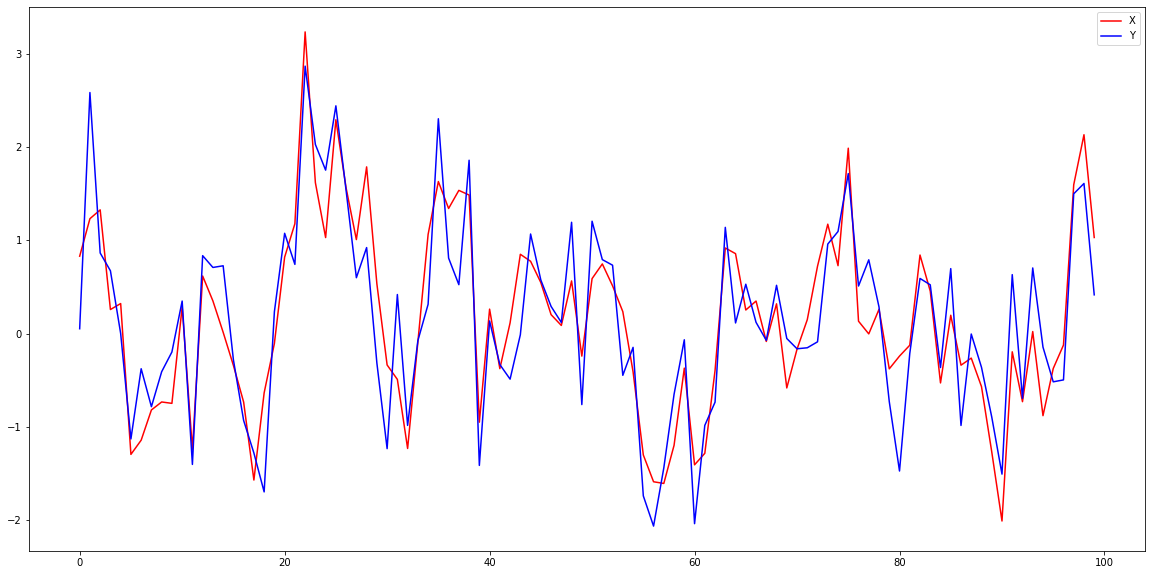

In [560]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(X[:100], c='r', label='X')
ax.plot(Y[:100], c='b', label='Y')
plt.legend()

### <span style='color:black'>   3.1 Estimation des paramètres a,b - non supervisé </span>

In [561]:
ab2 = 0
for i in range(len(Y)-1):
    ab2 += (Y[i]*Y[i+1])
ab2 = ab2 / (len(Y)-1)

a2b2 = 0
for i in range(len(Y)-2):
    a2b2 += (Y[i]*Y[i+2])
a2b2 = a2b2 / (len(Y)-2)

print("ab2 = {} - a2b2 = {}".format(ab2,a2b2))

ab2 = 0.4684381378248499 - a2b2 = 0.27948604230116547


In [562]:
a = a2b2 / ab2
b = np.sqrt(ab2 / a)

print("a = {} - b = {}".format(a,b))

a = 0.5966338342965276 - b = 0.8860784695470207


### <span style='color:black'>   3.2 Filtre de Kalman </span>

In [570]:
"Notations : t_t = t/t, t1 = t+1 / t1_t = t+1/t "
# Initialisation : 

X_chap = [b*Y[0]]
σ_t_t = 1 - b**2

# Récursion:

for i in range(len(Y)-1):
    # Etape 1 : Prédiction
    X_chap_t1_t = a * X_chap[i]
    σ_t1_t = 1 - a**2 + a**2 * σ_t_t

    # Etape 2 : Mise à jour
    Y_chap_t1 = Y[i+1] - b * X_chap_t1_t
    S_t1 = b**2 * σ_t1_t + 1 - b**2
    K_t1 = b / S_t1 * σ_t1_t
    X_chap.append(X_chap_t1_t + K_t1 * Y_chap_t1)
    σ_t1_t1 = (1 - b * K_t1) * σ_t1_t
X_chap = np.array(X_chap)

In [570]:
"Notations : t_t = t/t, t1 = t+1 / t1_t = t+1/t "
# Initialisation : 

X_chap = [b*Y[0]]
σ_t_t = 1 - b**2

# Récursion:

for i in range(len(Y)-1):
    # Etape 1 : Prédiction
    X_chap_t1_t = a * X_chap[i]
    σ_t1_t = 1 - a**2 + a**2 * σ_t_t

    # Etape 2 : Mise à jour
    Y_chap_t1 = Y[i+1] - b * X_chap_t1_t
    S_t1 = b**2 * σ_t1_t + 1 - b**2
    K_t1 = b / S_t1 * σ_t1_t
    X_chap.append(X_chap_t1_t + K_t1 * Y_chap_t1)
    σ_t1_t1 = (1 - b * K_t1) * σ_t1_t
X_chap = np.array(X_chap)

In [571]:
X_chap

array([ 0.04619194,  2.12182635,  1.05570641, ...,  0.70069786,
        0.13582695, -0.57022396])

### <span style='color:black'>   3.3 Evaluation de l'erreur </span>

In [583]:
def Erreur(X,Y):
    return np.round(((X-Y)**2).sum()/len(X)*100,2)

In [586]:
#Erreur entre signal bruité et signal réel
err_réel = Erreur(X,Y)
print("L'erreur quadratique entre le signal réel et le signal bruité : {} %".format(err_réel))

L'erreur quadratique entre le signal réel et le signal bruité : 20.23 %


In [587]:
#Erreur entre signal bruité et signal réel
err_filtré = Erreur(X,X_chap)
print("L'erreur quadratique entre le signal réel et le signal restauré : {} %".format(err_filtré))

L'erreur quadratique entre le signal réel et le signal restauré : 17.45 %


- <span style='color:red'><b>Commentaire</b></span>  
Nous remarquons que l'erreur quadratique entre le signal de base et le signal restauré est inférieure à l'erreur quadratique moyenne entre le signal de base et le signal bruité

### <span style='color:black'>   3.4 Affichage des signaux </span>

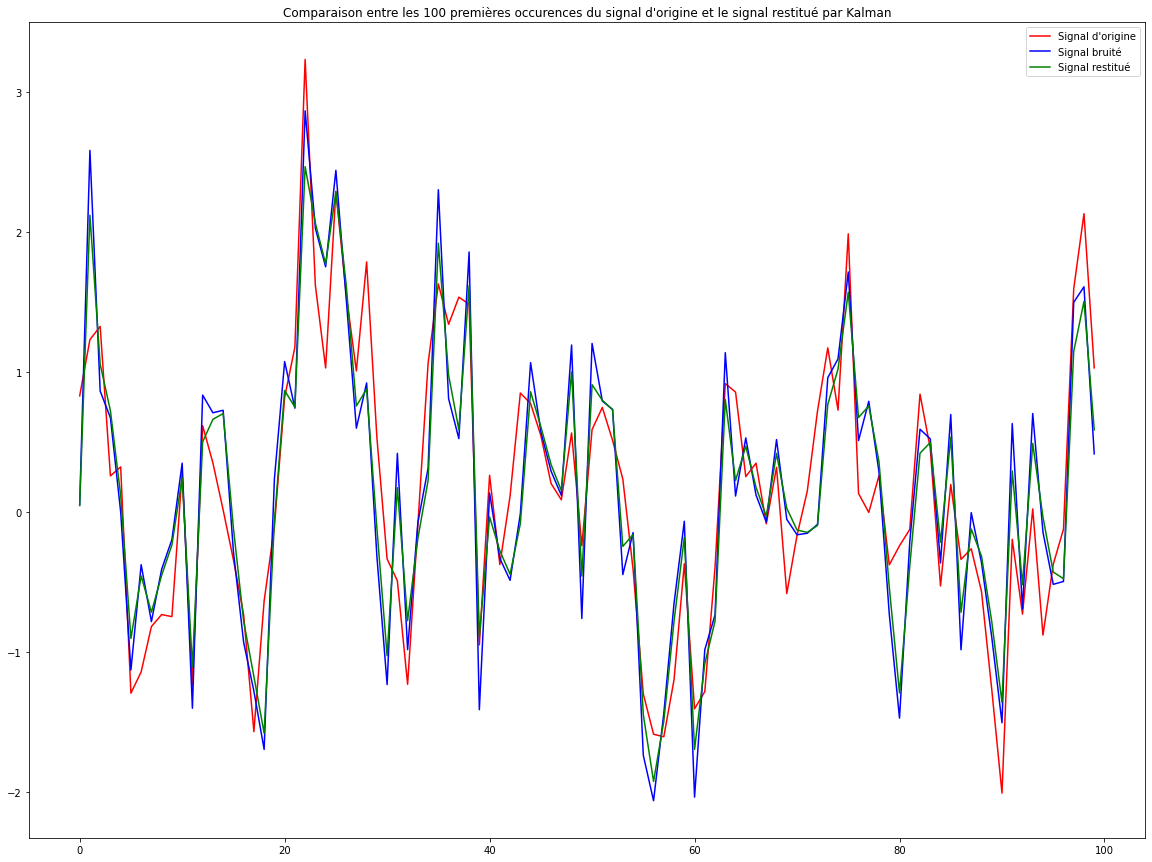

In [582]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(X[:100], c='r', label="Signal d'origine")
ax.plot(Y[:100], c='b', label='Signal bruité')
ax.plot(X_chap[:100], c='g', label='Signal restitué')

plt.title("Comparaison entre les 100 premières occurences du signal d'origine et le signal restitué par Kalman")
plt.legend()